# Financial Planning with APIs and Simulations

In this Challenge, you’ll create two financial analysis tools by using a single Jupyter notebook:

Part 1: A financial planner for emergencies. The members will be able to use this tool to visualize their current savings. The members can then determine if they have enough reserves for an emergency fund.

Part 2: A financial planner for retirement. This tool will forecast the performance of their retirement portfolio in 30 years. To do this, the tool will make an Alpaca API call via the Alpaca SDK to get historical price data for use in Monte Carlo simulations.

You’ll use the information from the Monte Carlo simulation to answer questions about the portfolio in your Jupyter notebook.



In [1]:
# Import the required libraries and dependencies
import os
import requests
import json
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
from datetime import date, timedelta
import datetime

%matplotlib inline

In [2]:
# Load the environment variables from the .env file
#by calling the load_dotenv function
load_dotenv()

True

In [3]:
# The current number of coins for each cryptocurrency asset held in the portfolio.
btc_coins = 1.2
eth_coins = 5.3

#### Step 1: Create a variable named `monthly_income`, and set its value to `12000`.

In [4]:
# The monthly amount for the member's household income
monthly_income = 12000


In [5]:
# The Free Crypto API Call endpoint URLs for the held cryptocurrency assets
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [6]:
# Using the Python requests library, make an API call to access the current price of BTC
btc_response = requests.get(btc_url).json()

# Use the json.dumps function to review the response data from the API call
# Use the indent and sort_keys parameters to make the response object readable
print(json.dumps(btc_response, indent=4, sort_keys=True))


{
    "data": {
        "1": {
            "circulating_supply": 19130950,
            "id": 1,
            "last_updated": 1661371779,
            "max_supply": 21000000,
            "name": "Bitcoin",
            "quotes": {
                "USD": {
                    "market_cap": 416157018905,
                    "percent_change_1h": -0.0856518264048271,
                    "percent_change_24h": 0.58673423971963,
                    "percent_change_7d": -9.32632863377992,
                    "percentage_change_1h": -0.0856518264048271,
                    "percentage_change_24h": 0.58673423971963,
                    "percentage_change_7d": -9.32632863377992,
                    "price": 21683.0,
                    "volume_24h": 26982365734
                }
            },
            "rank": 1,
            "symbol": "BTC",
            "total_supply": 19130950,
            "website_slug": "bitcoin"
        }
    },
    "metadata": {
        "error": null,
        "num_cryptocurre

In [7]:
# Using the Python requests library, make an API call to access the current price ETH
eth_response = requests.get(eth_url).json()

# Use the json.dumps function to review the response data from the API call
# Use the indent and sort_keys parameters to make the response object readable
print(json.dumps(eth_response, indent=4, sort_keys=True))


{
    "data": {
        "1027": {
            "circulating_supply": 120234767,
            "id": 1027,
            "last_updated": 1661371722,
            "max_supply": 120234767,
            "name": "Ethereum",
            "quotes": {
                "USD": {
                    "market_cap": 202267716349,
                    "percent_change_1h": 0.177329015280866,
                    "percent_change_24h": 1.31017663862234,
                    "percent_change_7d": -10.8544596281513,
                    "percentage_change_1h": 0.177329015280866,
                    "percentage_change_24h": 1.31017663862234,
                    "percentage_change_7d": -10.8544596281513,
                    "price": 1676.47,
                    "volume_24h": 15605707909
                }
            },
            "rank": 2,
            "symbol": "ETH",
            "total_supply": 120234767,
            "website_slug": "ethereum"
        }
    },
    "metadata": {
        "error": null,
        "num_cryp

In [8]:
# Navigate the BTC response object to access the current price of BTC
btc_price = btc_response['data']['1']['quotes']['USD']['price']

# Print the current price of BTC
print(f"The current price of BTC is {btc_price}")


The current price of BTC is 21683.0


In [9]:
# Navigate the BTC response object to access the current price of ETH
eth_price = eth_response['data']['1027']['quotes']['USD']['price']

# Print the current price of ETH
print(f"The current price of ETH is {eth_price}")


The current price of ETH is 1676.47


In [10]:
# Compute the current value of the BTC holding 
btc_value = btc_price * btc_coins

# Print current value of your holding in BTC
print("${:0,.2f}".format(btc_value))

$26,019.60


In [11]:
# Compute the current value of the ETH holding 
eth_value = eth_price * eth_coins
print("${:0,.2f}".format(eth_value))
# Print current value of your holding in ETH

$8,885.29


In [12]:
# Compute the total value of the cryptocurrency wallet
# Add the value of the BTC holding to the value of the ETH holding
total_crypto_wallet = btc_value + eth_value

# Print current cryptocurrency wallet balance
print("${:0,.2f}".format(total_crypto_wallet))


$34,904.89


In [13]:
# Current amount of shares held in both the stock (SPY) and bond (AGG) portion of the portfolio.
spy_shares = 110
agg_shares = 200


In [14]:
# Set the variables for the Alpaca API and secret keys
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca tradeapi.REST object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")


In [15]:
# Set the tickers for both the bond and stock portion of the portfolio
tickers = ["SPY", "AGG"]

# Set timeframe to 1Day
timeframe = "1Day"

# Format current date as ISO format
# Set both the start and end date at the date of your prior weekday 
# This will give you the closing price of the previous trading day
# Alternatively you can use a start and end date of 2020-08-07
start_date = pd.Timestamp("2020-08-07", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-08-07", tz="America/New_York").isoformat()


In [16]:
# Use the Alpaca get_bars function to get current closing prices the portfolio
# Be sure to set the `df` property after the function to format the response object as a DataFrame
prices_df = alpaca.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

# Reorganize the DataFrame
# Separate ticker data
SPY = prices_df[prices_df['symbol']=='SPY'].drop('symbol', axis=1)
AGG = prices_df[prices_df['symbol']=='AGG'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
prices_df = pd.concat([SPY, AGG], axis=1, keys=["SPY", "AGG"])

# Review the first 5 rows of the Alpaca DataFrame
prices_df.head()


SPY                                   \
                             open    high    low   close    volume   
timestamp                                                            
2020-08-07 04:00:00+00:00  333.29  334.88  332.3  334.57  57282821   

                                                      AGG                   \
                          trade_count        vwap    open    high      low   
timestamp                                                                    
2020-08-07 04:00:00+00:00      350100  333.800372  119.66  119.73  119.395   

                                                                    
                            close   volume trade_count        vwap  
timestamp                                                           
2020-08-07 04:00:00+00:00  119.43  5559066       15246  119.475306

In [17]:
# Access the closing price for AGG from the Alpaca DataFrame
# Converting the value to a floating point number
agg_close_price = float(prices_df["AGG"]["close"])

# Print the AGG closing price
print("The closing price of AGG on 08/07/2020 was ${:0,.2f}".format(agg_close_price))



The closing price of AGG on 08/07/2020 was $119.43


In [18]:
# Access the closing price for SPY from the Alpaca DataFrame
# Converting the value to a floating point number
spy_close_price = prices_df["SPY"]["close"]
spy_close_price = float(spy_close_price)

# Print the SPY closing price
print("The closing price of SPY on 08/07/2020 was ${:0,.2f}".format(spy_close_price))


The closing price of SPY on 08/07/2020 was $334.57


In [19]:
# Calculate the current value of the bond portion of the portfolio
agg_value = agg_close_price * agg_shares

# Print the current value of the bond portfolio
print("The current value of the bond portion is ${:0,.2f}".format(agg_value))


The current value of the bond portion is $23,886.00


In [20]:
# Calculate the current value of the stock portion of the portfolio
spy_value = spy_close_price * spy_shares


# Print the current value of the stock portfolio
print("The current value of the stock portion is ${:0,.2f}".format(spy_value))


The current value of the stock portion is $36,802.70


In [21]:
# Calculate the total value of the stock and bond portion of the portfolio
total_stocks_bonds = agg_value + spy_value

# Print the current balance of the stock and bond portion of the portfolio
print("The current value of the total portfolio is ${:0,.2f}".format(total_stocks_bonds))


The current value of the total portfolio is $60,688.70


In [22]:
# Calculate the total value of the member's entire savings portfolio
# Add the value of the cryptocurrency walled to the value of the total stocks and bonds
total_portfolio = total_crypto_wallet + total_stocks_bonds

# Print current cryptocurrency wallet balance

#NOTE I'm not sure why you would have us print this value again
print("The current value of the current cryptocurrency wallet is ${:0,.2f}".format(total_crypto_wallet))


The current value of the current cryptocurrency wallet is $34,904.89


In [23]:
# Consolidate financial assets data into a Python list
savings_data = [total_crypto_wallet, total_stocks_bonds]

# Review the Python list savings_data
savings_data
    

[34904.890999999996, 60688.7]

In [24]:
# Create a Pandas DataFrame called savings_df 
savings_df = pd.DataFrame(savings_data, columns=["amount"], index=["crypto", "stock/bond"])
    

# Display the savings_df DataFrame
display(savings_df)
                          

,amount
crypto,34904.891
stock/bond,60688.700


<AxesSubplot:title={'center':'Stocks vs Bonds'}, ylabel='amount'>

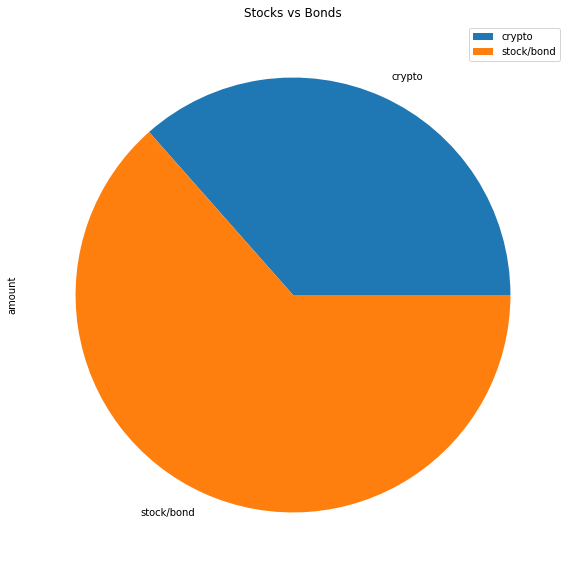

In [25]:
# Plot the total value of the member's portfolio (crypto and stock/bond) in a pie chart
savings_df.plot(
    kind = 'pie',
    title="Stocks vs Bonds", 
    figsize=(10,10), 
    y='amount'
)


In [26]:
# Create a variable named emergency_fund_value
emergency_fund_value = 3 * monthly_income


In [27]:
# Evaluate the possibility of creating an emergency fund with 3 conditions:
if total_portfolio > emergency_fund_value:
    print("Congratulations! You have enough money in this fund.")
# YOUR CODE HERE
if total_portfolio == emergency_fund_value:
    print("Congratulations! You have reached an important financial goal.")
# YOUR CODE HERE
if total_portfolio < emergency_fund_value:
    print("You need ${:0,.2f} to achieve this goal".format(emergency_fund_value - total_portfolio))


Congratulations! You have enough money in this fund.


In [28]:
# Set start and end dates of 3 years back from your current date
# Alternatively, you can use an end date of 2020-08-07 and work 3 years back from that date 
start_date = pd.Timestamp("2017-08-07", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-08-07", tz="America/New_York").isoformat()

In [29]:
# Use the Alpaca get_bars function to make the API call to get the 3 years worth of pricing data
# The tickers and timeframe parameters should have been set in Part 1 of this activity 
# The start and end dates should be updated with the information set above
# Remember to add the df property to the end of the call so the response is returned as a DataFrame
prices_df = alpaca.get_bars(
    tickers,
    timeframe,
    start=pd.Timestamp("2017-08-07", tz="America/New_York").isoformat(),
    end=pd.Timestamp("2020-08-07", tz="America/New_York").isoformat()
).df

# Reorganize the DataFrame
# Separate ticker data
SPY = prices_df[prices_df['symbol']=='SPY'].drop('symbol', axis=1)
AGG = prices_df[prices_df['symbol']=='AGG'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
prices_df = pd.concat([SPY, AGG], axis=1, keys=["SPY", "AGG"])

# Display both the first and last five rows of the DataFrame
prices_df.head()
prices_df.tail()


SPY                                    \
                             open    high     low   close    volume   
timestamp                                                             
2020-08-03 04:00:00+00:00  328.31  329.62  327.73  328.79  53078112   
2020-08-04 04:00:00+00:00  327.88  330.06  327.86  330.06  41917896   
2020-08-05 04:00:00+00:00  331.46  332.39  331.18  332.11  42870955   
2020-08-06 04:00:00+00:00  331.52  334.46  331.13  334.33  43679448   
2020-08-07 04:00:00+00:00  333.29  334.88  332.30  334.57  57282821   

                                                      AGG                    \
                          trade_count        vwap    open    high       low   
timestamp                                                                     
2020-08-03 04:00:00+00:00      288003  328.658795  119.37  119.40  119.1903   
2020-08-04 04:00:00+00:00      250899  329.057592  119.42  119.63  119.4200   
2020-08-05 04:00:00+00:00      241416  331.791643  119.39  119.49  119.3100   
2020-08-06 04:00:00+00:00      290036  332.939600  119.62  119.73  119.5300   
2020-08-07 04:00:00+00:00      350100  333.800372  119.66  119.73  119.3950   

                                                                     
                            close    volume trade_count        vwap  
timestamp                                                            
2020-08-03 04:00:00+00:00  119.40  13014535       36359  119.282420  
2020-08-04 04:00:00+00:00  119.63  10935154       39113  119.541666  
2020-08-05 04:00:00+00:00  119.40  17377874       42313  119.387245  
2020-08-06 04:00:00+00:00  119.57   4608710       15938  119.604199  
2020-08-07 04:00:00+00:00  119.43   5559066       15246  119.475306

#### Step 2: Run a Monte Carlo simulation of 500 samples and 30 years for the 60/40 portfolio, and then plot the results.

In [30]:
# Configure the Monte Carlo simulation to forecast 30 years cumulative returns
# The weights should be split 40% to AGG and 60% to SPY.
# Run 500 samples.
MC_even_weight_30_year = MCSimulation(
    portfolio_data = prices_df,
    weights = [.60,.40],
    num_simulation = 500,
    num_trading_days = 252*30
)


# Review the simulation input data
MC_even_weight_30_year.portfolio_data.head()


SPY                                     \
                             open    high     low   close     volume   
timestamp                                                              
2017-08-07 04:00:00+00:00  247.50  247.87  247.37  247.87   31995021   
2017-08-08 04:00:00+00:00  247.49  248.91  246.83  247.26   61719353   
2017-08-09 04:00:00+00:00  246.46  247.31  246.06  247.25   62632619   
2017-08-10 04:00:00+00:00  246.30  246.44  243.70  243.76  120418270   
2017-08-11 04:00:00+00:00  244.00  244.80  243.75  244.12   74869947   

                                                                   AGG  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-08-07 04:00:00+00:00      100111  247.668698          NaN  109.69   
2017-08-08 04:00:00+00:00      192921  247.739709    -0.002461  109.67   
2017-08-09 04:00:00+00:00      223650  246.791421    -0.000040  109.87   
2017-08-10 04:00:00+00:00      424321  245.027847    -0.014115  109.70   
2017-08-11 04:00:00+00:00      278786  244.222867     0.001477  109.75   

                                                                          \
                             high       low   close   volume trade_count   
timestamp                                                                  
2017-08-07 04:00:00+00:00  109.72  109.6066  109.67  2359826        7755   
2017-08-08 04:00:00+00:00  109.69  109.5000  109.57  2570876       12663   
2017-08-09 04:00:00+00:00  109.87  109.6600  109.67  2308932       11031   
2017-08-10 04:00:00+00:00  109.85  109.6700  109.78  2004163       12437   
2017-08-11 04:00:00+00:00  109.94  109.6800  109.87  1913253       10113   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-08-07 04:00:00+00:00  109.674876          NaN  
2017-08-08 04:00:00+00:00  109.577636    -0.000912  
2017-08-09 04:00:00+00:00  109.771749     0.000913  
2017-08-10 04:00:00+00:00  109.776611     0.001003  
2017-08-11 04:00:00+00:00  109.860974     0.000820

In [31]:
# Run the Monte Carlo simulation to forecast 30 years cumulative returns
MC_even_weight_30_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/avancamp/Documents/school/weekly_challenges/module_5/Starter_Code /MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000740,1.007851,0.993896,0.998345,0.990762,0.995210,1.013480,1.007746,0.989468,1.010537,...,1.004231,0.990509,1.007757,1.007477,0.996583,1.002907,1.002589,1.006824,1.001175,1.004187
2,1.015740,1.009733,0.987659,1.007932,0.987002,1.000440,1.007063,1.002727,0.974874,1.013027,...,1.006581,0.990987,0.999004,1.011664,0.985350,1.004740,1.003373,1.013095,1.000029,1.002969
3,1.027126,1.023537,0.993443,1.001575,0.993199,0.997736,0.996436,1.004234,0.966889,1.012546,...,1.005356,0.984988,0.999239,0.997610,0.984191,1.006383,1.011145,1.006943,0.989589,0.996706
4,1.028611,1.020323,0.988883,1.003808,0.997198,0.997578,0.987120,1.008334,0.969434,0.999450,...,0.988039,0.975980,0.999558,1.005071,0.981759,1.018037,1.017966,1.000417,0.976683,1.014552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,2.431780,11.965506,15.541616,16.006727,36.341186,1.860478,2.830463,13.598708,10.299891,12.999365,...,7.655680,17.948453,27.350981,5.586620,7.903310,19.951552,10.905611,6.258626,27.704143,27.663573
7557,2.416222,12.070400,15.673422,16.121626,36.290770,1.861571,2.876199,13.610535,10.242265,12.857210,...,7.710032,17.654020,27.358776,5.510942,7.898102,20.214206,10.816605,6.311713,27.925643,27.554293
7558,2.409006,12.098773,15.588660,16.311435,36.188804,1.815394,2.882870,13.880944,10.163681,12.841941,...,7.651372,17.876416,27.673877,5.499774,7.892680,20.482544,10.688412,6.357186,28.443561,27.596473
7559,2.369618,11.983211,15.425973,16.290779,36.538772,1.818485,2.888271,14.018220,9.918533,12.826560,...,7.584201,17.718485,27.785070,5.564102,7.868447,20.337686,10.827732,6.271006,28.401556,27.325703


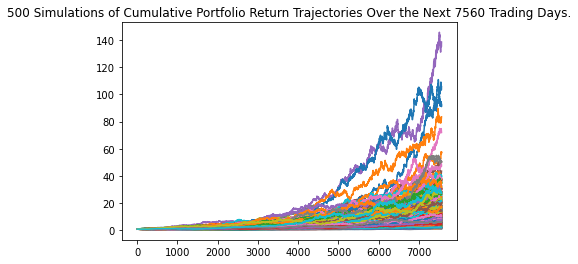

In [32]:
# Visualize the 30-year Monte Carlo simulation by creating an
# overlay line plot
even_weight_30_year_line_plot = MC_even_weight_30_year.plot_simulation()


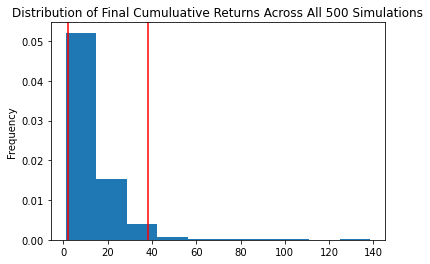

In [33]:
# Visualize the probability distribution of the 30-year Monte Carlo simulation 
# by plotting a histogram
even_weight_30_year_distribution_plot = MC_even_weight_30_year.plot_distribution()


In [34]:
# Generate summary statistics from the 30-year Monte Carlo simulation results
# Save the results as a variable
even_weight_30_year_table = MC_even_weight_30_year.summarize_cumulative_return()

# Review the 30-year Monte Carlo summary statistics
even_weight_30_year_table

count           500.000000
mean             13.426373
std              12.672530
min               1.175328
25%               6.304866
50%               9.792308
75%              16.072082
max             138.491702
95% CI Lower      2.276771
95% CI Upper     38.207831
Name: 7560, dtype: float64

In [35]:
# Print the current balance of the stock and bond portion of the members portfolio
print("The current value of the stock portion is ${:0,.2f}".format(spy_value))
print("The current value of the bond portion is ${:0,.2f}".format(agg_value))


The current value of the stock portion is $36,802.70
The current value of the bond portion is $23,886.00


In [36]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the current stock/bond portfolio
lower_return_30_year = round(even_weight_30_year_table[8]*15000,2)
upper_return_30_year = round(even_weight_30_year_table[9]*15000,2)
# Print the result of your calculations
print(f"The possible outcomes of this portfolio are ${lower_return_30_year} to ${upper_return_30_year}.")


The possible outcomes of this portfolio are $34151.56 to $573117.47.


In [37]:
# Configure a Monte Carlo simulation to forecast 10 years cumulative returns
# The weights should be split 20% to AGG and 80% to SPY.
# Run 500 samples.
MC_even_weight_10_year = MCSimulation(
    portfolio_data = prices_df,
    weights = [.80,.20],
    num_simulation = 500,
    num_trading_days = 252*10
)

# Review the simulation input data
MC_even_weight_10_year.portfolio_data.head()


SPY                                     \
                             open    high     low   close     volume   
timestamp                                                              
2017-08-07 04:00:00+00:00  247.50  247.87  247.37  247.87   31995021   
2017-08-08 04:00:00+00:00  247.49  248.91  246.83  247.26   61719353   
2017-08-09 04:00:00+00:00  246.46  247.31  246.06  247.25   62632619   
2017-08-10 04:00:00+00:00  246.30  246.44  243.70  243.76  120418270   
2017-08-11 04:00:00+00:00  244.00  244.80  243.75  244.12   74869947   

                                                                   AGG  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-08-07 04:00:00+00:00      100111  247.668698          NaN  109.69   
2017-08-08 04:00:00+00:00      192921  247.739709    -0.002461  109.67   
2017-08-09 04:00:00+00:00      223650  246.791421    -0.000040  109.87   
2017-08-10 04:00:00+00:00      424321  245.027847    -0.014115  109.70   
2017-08-11 04:00:00+00:00      278786  244.222867     0.001477  109.75   

                                                                          \
                             high       low   close   volume trade_count   
timestamp                                                                  
2017-08-07 04:00:00+00:00  109.72  109.6066  109.67  2359826        7755   
2017-08-08 04:00:00+00:00  109.69  109.5000  109.57  2570876       12663   
2017-08-09 04:00:00+00:00  109.87  109.6600  109.67  2308932       11031   
2017-08-10 04:00:00+00:00  109.85  109.6700  109.78  2004163       12437   
2017-08-11 04:00:00+00:00  109.94  109.6800  109.87  1913253       10113   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-08-07 04:00:00+00:00  109.674876          NaN  
2017-08-08 04:00:00+00:00  109.577636    -0.000912  
2017-08-09 04:00:00+00:00  109.771749     0.000913  
2017-08-10 04:00:00+00:00  109.776611     0.001003  
2017-08-11 04:00:00+00:00  109.860974     0.000820

In [38]:
# Run the Monte Carlo simulation to forecast 10 years cumulative returns
MC_even_weight_10_year.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/avancamp/Documents/school/weekly_challenges/module_5/Starter_Code /MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.990666,1.008718,0.996843,0.994313,0.987433,1.020173,0.985456,1.015243,0.977701,1.002068,...,1.008319,0.993365,1.003955,1.004734,0.998304,1.010350,1.017022,0.984739,0.989797,1.020581
2,0.992350,1.027135,0.984088,0.989670,0.980471,1.026191,0.990954,1.030789,0.954023,1.008935,...,1.028426,1.008122,1.003165,1.009785,0.978961,1.002678,1.014743,0.995943,0.975374,1.006890
3,0.995436,1.025237,0.990132,0.976078,0.972200,1.026820,1.003481,1.060697,0.950691,0.993740,...,1.037626,1.006516,0.987443,1.013683,0.983347,1.001107,1.002757,0.996128,0.990354,1.008184
4,1.001311,1.028908,1.001211,0.971162,0.967115,1.016577,1.013831,1.072821,0.959838,0.978367,...,1.044426,1.007471,0.996039,1.006118,0.999720,0.995579,1.008909,1.000562,0.995580,1.024028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,5.181837,2.499291,4.758335,1.354481,1.370551,3.684663,2.115467,10.073048,0.569698,3.308609,...,3.028184,4.260715,5.884132,4.376996,3.260293,3.999367,5.173733,1.854944,3.181103,5.711068
2517,5.215521,2.540562,4.746764,1.343578,1.347584,3.689130,2.141500,10.030558,0.572992,3.278117,...,3.051143,4.300390,6.049615,4.407651,3.266018,3.960126,5.092038,1.854269,3.187907,5.692322
2518,5.243002,2.556265,4.712367,1.346043,1.339846,3.699640,2.142023,10.047949,0.569819,3.287698,...,3.010654,4.209722,6.080559,4.461916,3.237977,3.986565,5.176017,1.847872,3.204785,5.721392
2519,5.257895,2.543895,4.637431,1.365099,1.339397,3.667220,2.134956,9.819197,0.569514,3.200074,...,2.978802,4.264929,6.057671,4.501133,3.221903,3.961064,5.079978,1.863169,3.267038,5.798381


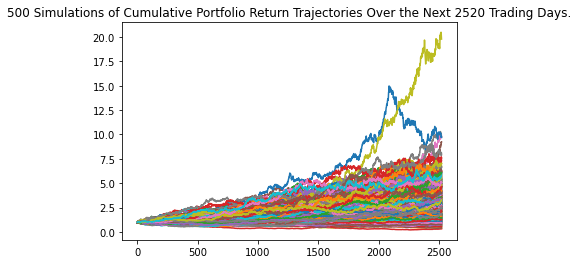

In [39]:
# Visualize the 10-year Monte Carlo simulation by creating an
# overlay line plot
even_weight_10_year_line_plot = MC_even_weight_10_year.plot_simulation()


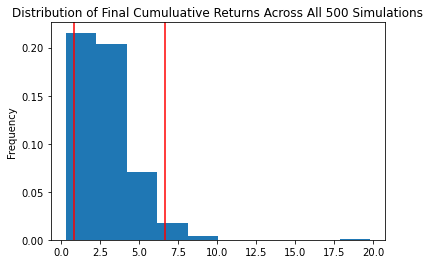

In [40]:
# Visualize the probability distribution of the 10-year Monte Carlo simulation 
# by plotting a histogram
even_weight_10_year_distribution_plot_10_year = MC_even_weight_10_year.plot_distribution()


In [41]:
# Generate summary statistics from the 10-year Monte Carlo simulation results
# Save the results as a variable
even_weight_10_year_table = MC_even_weight_10_year.summarize_cumulative_return()


# Review the 10-year Monte Carlo summary statistics
even_weight_10_year_table

count           500.000000
mean              2.914220
std               1.771173
min               0.308868
25%               1.711595
50%               2.549730
75%               3.612057
max              19.794253
95% CI Lower      0.822793
95% CI Upper      6.688443
Name: 2520, dtype: float64

In [42]:
# Print the current balance of the stock and bond portion of the members portfolio
print(total_stocks_bonds)


60688.7


In [43]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the current stock/bond portfolio
lower_return_10_year = round(even_weight_10_year_table[8]*15000,2)
upper_return_10_year = round(even_weight_10_year_table[9]*15000,2)
# Print the result of your calculations
print(f"The possible outcomes of this portfolio are ${lower_return_10_year} to ${upper_return_10_year}.")


The possible outcomes of this portfolio are $12341.89 to $100326.64.
